## Genes pronóstico en el microambiente tumoral de glioma de bajo grado

En este cuaderno se procede con la metodología propuesta en el artículo https://pubmed.ncbi.nlm.nih.gov/32309356, adaptada a un flujo de trabajo completo con Python. 

Los datos analizados fueron obtenidos del sitio https://www.linkedomics.org/data_download/TCGA-LGG.

Datos de expresión génica obtenidos por secuenciación masiva de ARN mediante la plataforma Illumina HiSeq. Son datos agegados o resumidos para cada gen, no para isoformas o transcritos específicos. Valores de expresión transcriptómica calculados con RSEM y transformados con logaritmo en base 2 para estabilizar varianza, sumado 1 para evitar log(O). Contiene 516 muestras tumorales de LGG (Lower Grade Glioma) y 20086 genes.

Los datos clínicos se refieren al género del paciente, edad al diagnóstico, etnia y raza, supervivenci global en días, estado (vivo o fallecido), tipo histológico (astrocytoma, oligodendroglioma, oligoastrocytoma) e información sobre radioterapia.

## Carga de los datos

In [74]:
import pandas as pd
import numpy as np

path_clinico = 'data/Human__TCGA_LGG__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi.txt'
path_genes = 'data/Human__TCGA_LGG__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct'

clin = pd.read_csv(path_clinico, sep='\t', index_col=0)
expr = pd.read_csv(path_genes, sep='\t', index_col=0)

print(f"Dimensión datos expresión: {expr.shape}")  # espera genes x muestras
print(f"Dimensión datos clínicos: {clin.shape}")


Dimensión datos expresión: (20086, 516)
Dimensión datos clínicos: (10, 515)


In [75]:
clin.head()

TCGA.CS.6665       TCGA.CS.6670      TCGA.DB.A4XC  \
attrib_name                                                           
years_to_birth              51                 43                26   
Tumor_purity            0.6573             0.9816            0.8892   
histological_type  astrocytoma  oligodendroglioma  oligoastrocytoma   
gender                  female               male              male   
radiation_therapy          yes                NaN               yes   

                        TCGA.DH.5141 TCGA.DH.A66B       TCGA.DU.7300  \
attrib_name                                                            
years_to_birth                    32           52                 53   
Tumor_purity                  0.9387       0.8806             0.9302   
histological_type  oligodendroglioma  astrocytoma  oligodendroglioma   
gender                          male         male             female   
radiation_therapy                yes          yes                 no   

                  TCGA.DU.A76O TCGA.E1.A7YN      TCGA.FG.8187  \
attrib_name                                                     
years_to_birth              30           63                31   
Tumor_purity             0.836       0.5498            0.9313   
histological_type  astrocytoma  astrocytoma  oligoastrocytoma   
gender                    male       female              male   
radiation_therapy          yes          yes                no   

                       TCGA.FG.A60K  ... TCGA.VW.A8FI       TCGA.W9.A837  \
attrib_name                          ...                                   
years_to_birth                   34  ...           66                NaN   
Tumor_purity                 0.9553  ...       0.8816             0.9888   
histological_type  oligoastrocytoma  ...  astrocytoma  oligodendroglioma   
gender                       female  ...         male               male   
radiation_therapy                no  ...          yes                 no   

                  TCGA.WH.A86K TCGA.WY.A858 TCGA.WY.A859 TCGA.WY.A85A  \
attrib_name                                                             
years_to_birth              65           32           34           20   
Tumor_purity            0.9243       0.7115       0.9966       0.9432   
histological_type  astrocytoma  astrocytoma  astrocytoma  astrocytoma   
gender                    male       female       female         male   
radiation_therapy           no          yes          yes           no   

                  TCGA.WY.A85B TCGA.WY.A85C      TCGA.WY.A85D  \
attrib_name                                                     
years_to_birth              24           36                60   
Tumor_purity             0.836       0.9311            0.9167   
histological_type  astrocytoma  astrocytoma  oligoastrocytoma   
gender                    male         male              male   
radiation_therapy           no          yes                no   

                       TCGA.WY.A85E  
attrib_name                          
years_to_birth                   48  
Tumor_purity                  0.973  
histological_type  oligoastrocytoma  
gender                       female  
radiation_therapy                no  

[5 rows x 515 columns]

In [76]:
expr.head()

TCGA.CS.4938  TCGA.CS.4941  TCGA.CS.4942  TCGA.CS.4943  \
attrib_name                                                           
A1BG               6.5715        6.1944        6.2375        4.9535   
A1CF               0.0000        0.0000        0.0000        0.0000   
A2BP1              4.5641        9.0375        8.5295        5.5235   
A2LD1              3.8564        7.1808        5.7117        3.9052   
A2ML1              7.1997        9.0290        7.4545        7.4920   

             TCGA.CS.4944  TCGA.CS.5390  TCGA.CS.5393  TCGA.CS.5394  \
attrib_name                                                           
A1BG               4.6844        6.4341        5.5662        5.2841   
A1CF               0.0000        0.0000        0.0000        0.0000   
A2BP1              6.7335        8.2774        8.3424        4.3743   
A2LD1              4.2491        4.3597        4.9114        3.1034   
A2ML1              7.3253        6.2381        7.3717        6.0127   

             TCGA.CS.5395  TCGA.CS.5396  ...  TCGA.VW.A8FI  TCGA.W9.A837  \
attrib_name                              ...                               
A1BG               4.3587        6.5179  ...        7.2362        4.7140   
A1CF               0.0000        0.0000  ...        0.0000        0.0000   
A2BP1              8.2314        3.5902  ...        4.7021       10.2611   
A2LD1              7.6662        4.2153  ...        6.5365        4.6135   
A2ML1              9.8985        4.0029  ...        6.1683        7.9353   

             TCGA.WH.A86K  TCGA.WY.A858  TCGA.WY.A859  TCGA.WY.A85A  \
attrib_name                                                           
A1BG               8.4603        7.7583        6.1011        6.3097   
A1CF               0.0000        0.0000        0.0000        0.0000   
A2BP1              6.0157        2.6741       11.2508        7.4914   
A2LD1              5.2138        5.3648        4.5050        4.8743   
A2ML1              8.9790        5.5743        7.8376        8.3211   

             TCGA.WY.A85B  TCGA.WY.A85C  TCGA.WY.A85D  TCGA.WY.A85E  
attrib_name                                                          
A1BG               6.4383        6.9881        8.2396        7.0297  
A1CF               0.0000        0.4944        0.0000        0.0000  
A2BP1              5.4604        5.5221        4.7356        9.3438  
A2LD1              4.9876        4.5847        3.9758        3.7495  
A2ML1              5.3276        5.1757        8.0754        7.4474  

[5 rows x 516 columns]

Los datos originalmente se encuentran organizados en genes o características clínicas por fila y muestras por columnas.

Los datos de expresión génica están normalizados, al ser el objeto de estudio de la primera parte de la investigación no será necesario realizar un preprocesamiento.

## Cálculo de puntajes de microambientes

Mediante el algoritmo ESTIMATE (Estimation of STromal and Immune cells in MAlignant Tumor tissues using Expression data) se calcula: 
- Inmune Score: estimación de la infiltración de células inmunes en la muestra.
- Stromal Score: estimación de la presencia de células estromales.
- ESTIMATE Score: combinación que estima la pureza tumoral (negativamente correlacionada con las anteriores)

Los score se basan en el promedio de la expresión de genes característicos.

$$
\text{Score}_\text{immune} = \sum_{i \in G_{immune}} \text{Exp}_i
$$

$$
\text{Score}_\text{stromal} = \sum_{j \in G_{stromal}} \text{Exp}_j
$$

$$
S_{ESTIMATE} = S_{Immune} + S_{Stromal}
$$


donde $\text{Exp}_i$ es la expresión normalizada del gen marcador $i$.

In [77]:
# listas para immune y stromal genes
immune_genes = [
    "ACAP1", "ADAM28", "ADGRE3", "ATM", "BST2", "CD247", "CD27", "CD2", "CD3D", "CD3E",
    "CD3G", "CD52", "CD53", "CD6", "CD7", "CD8A", "CD8B", "CLEC4A", "CLEC7A", "CXCL9",
    "CXCR3", "CYBB", "DOCK2", "FCER1G", "FGR", "FOXP3", "GBP1", "GBP2", "GBP4", "GBP5",
    "GZMA", "GZMB", "HLA-DMA", "HLA-DMB", "HLA-DOA", "HLA-DOB", "HLA-DPA1", "HLA-DPB1",
    "HLA-DQA1", "HLA-DQA2", "HLA-DQB1", "HLA-DQB2", "HLA-DRA", "HLA-DRB1", "HLA-DRB5",
    "IFI16", "IFIH1", "IFIT3", "IL10RA", "IL2RA", "IRF8", "LAPTM5", "LAIR1", "LCP2", "LILRB2",
    "LILRB4", "LYN", "MS4A1", "MPEG1", "MX1", "NCKAP1L", "NLRC4", "NOD2", "NRP1", "P2RY12",
    "PTPRC", "PTPN7", "PTPN22", "SASH3", "SIRPA", "SLA", "SLAMF6", "SPI1", "STAT1", "STAT4",
    "SYK", "TBX21", "TLR1", "TLR3", "TLR6", "TLR7", "TREM2", "TRIM21", "TRIM68", "TYROBP",
    "WAS", "ZAP70", "CLEC12A", "S1PR4", "SPN", "CXCL10", "CXCL11", "CCL4", "CCL5", "CCR5",
    "CCR7", "CD40LG", "ITGAL", "PACSIN1", "SH2D1A", "PRKCB", "TAP1", "TAP2", "TAPBP",
    "TRIM25", "CD274", "PDCD1", "CTLA4", "TIGIT", "ICOS", "FOXP3", "IL7R", "GZMK", "NAT2",
    "HLA-A", "HLA-B", "HLA-C", "IFIT3"
]

stromal_genes = [
    "ABI3", "ACVRL1", "ADAM12", "ADAMTS12", "AEBP1", "AGRN", "ANGPT1", "ANTXR1",
    "AQP1", "ASPN", "BGN", "BMP4", "CDH11", "COL1A1", "COL1A2", "COL3A1", "COL5A1",
    "COL5A2", "COL6A1", "COL6A2", "COL6A3", "COL8A1", "COL8A2", "COMP", "CRTAC1",
    "DDIT4", "DCN", "DPT", "ELN", "ENG", "FAP", "FBN1", "FBLN2", "FBN3", "FCN3", "FGF7",
    "FHL2", "FLI1", "FN1", "FOXC1", "GJA4", "GJA5", "GLT8D2", "GREM1", "HAPLN1",
    "HAS2", "HGF", "HLF", "ICAM1", "IGFBP5", "ITGA11", "ITGA8", "ITGAX", "ITGB8",
    "JAM2", "KCNJ8", "KDR", "LAMA1", "LAMA2", "LAMA4", "LAMB1", "LAMC1", "LMO2",
    "MMP2", "MMP3", "MMP11", "MMP14", "MMP16", "MMP9", "MXRA5", "MYH11",
    "NID2", "PDGFA", "PDGFRA", "PDGFRB", "PECAM1", "PLOD1", "POSTN", "PTGS2",
    "RGS5", "RSPO3", "SCRG1", "SEMA3A", "SERPINE1", "SIGLEC1", "SLC2A3", "SLIT2",
    "SMOC2", "SPON1", "SPARC", "SPP1", "STC1", "TCF21", "TGFB3", "TIMP1", "TNC",
    "TNXB", "TPM1", "TPM2", "VCAN", "VWF", "WISP1", "XDH", "ZEB1", "ZNF423"
]

In [78]:
# filtrado de genes presentes en el dataset
immune_genes_present = [g for g in immune_genes if g in expr.index]
stromal_genes_present = [g for g in stromal_genes if g in expr.index]

print(f"Immune genes usados: {len(immune_genes_present)}")
print(f"Stromal genes usados: {len(stromal_genes_present)}")

# Calcular scores: promedio expresión de genes de cada set para cada muestra
immune_score = expr.loc[immune_genes_present].mean(axis=0)
stromal_score = expr.loc[stromal_genes_present].mean(axis=0)

# Score ESTIMATE, suma de scores
estimate_score = immune_score + stromal_score

# Unión en un DataFrame para análisis posterior
scores_df = pd.DataFrame({
    'immune_score': immune_score,
    'stromal_score': stromal_score,
    'estimate_score': estimate_score
})

scores_df.head()

Immune genes usados: 117
Stromal genes usados: 105


immune_score  stromal_score  estimate_score
TCGA.CS.4938      5.967111       7.132758       13.099869
TCGA.CS.4941      8.132838       8.345325       16.478163
TCGA.CS.4942      7.464896       7.209186       14.674081
TCGA.CS.4943      6.138782       7.550289       13.689071
TCGA.CS.4944      6.482274       7.448770       13.931043

## Preprocesamiento de dataset de variables clínicas

Es necesario modificar los tipos de datos a tipos adecuados para el trabajo como valores numéricos y el establecimiento de variables categoriales. La limpieza de los datos y eliminación de columnas innecesarias (la supervivencia está repetida)

In [79]:
clin = clin.T
clin.head()

attrib_name  years_to_birth Tumor_purity  histological_type  gender  \
TCGA.CS.6665             51       0.6573        astrocytoma  female   
TCGA.CS.6670             43       0.9816  oligodendroglioma    male   
TCGA.DB.A4XC             26       0.8892   oligoastrocytoma    male   
TCGA.DH.5141             32       0.9387  oligodendroglioma    male   
TCGA.DH.A66B             52       0.8806        astrocytoma    male   

attrib_name  radiation_therapy   race            ethnicity overall_survival  \
TCGA.CS.6665               yes  white  nothispanicorlatino             1568   
TCGA.CS.6670               NaN  white  nothispanicorlatino             1426   
TCGA.DB.A4XC               yes  white  nothispanicorlatino             1421   
TCGA.DH.5141               yes  white     hispanicorlatino              968   
TCGA.DH.A66B               yes  white  nothispanicorlatino             1279   

attrib_name  status overallsurvival  
TCGA.CS.6665      0          1568,0  
TCGA.CS.6670      0          1426,0  
TCGA.DB.A4XC      0          1421,0  
TCGA.DH.5141      0           968,0  
TCGA.DH.A66B      0          1279,0

In [80]:
clin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515 entries, TCGA.CS.6665 to TCGA.WY.A85E
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   years_to_birth     514 non-null    object
 1   Tumor_purity       515 non-null    object
 2   histological_type  515 non-null    object
 3   gender             515 non-null    object
 4   radiation_therapy  482 non-null    object
 5   race               505 non-null    object
 6   ethnicity          481 non-null    object
 7   overall_survival   481 non-null    object
 8   status             481 non-null    object
 9   overallsurvival    515 non-null    object
dtypes: object(10)
memory usage: 60.4+ KB


In [81]:
clin['overall_survival'] = pd.to_numeric(clin['overall_survival'], errors='coerce') # pasar días a numérico
clin = clin.drop(columns=['overallsurvival']) # eliminar por redundante

clin['years_to_birth'] = pd.to_numeric(clin['years_to_birth'], errors='coerce') # a numérico la edad

clin['Tumor_purity'] = pd.to_numeric(clin['Tumor_purity'], errors='coerce') # a float 

# categoriales
categorical_cols = ['histological_type', 'gender', 'radiation_therapy', 'race', 'ethnicity', 'status']
for col in categorical_cols:
    # Tomar valores no nulos y convertirlos a categorías
    clin[col] = clin[col].astype('category')

In [82]:
print(clin['status'].value_counts())

status
0    358
1    123
Name: count, dtype: int64


In [83]:
clin['status'] = pd.to_numeric(clin['status'], errors='coerce') # llevar status a numérico

In [84]:
print(clin.isna().sum())

attrib_name
years_to_birth        1
Tumor_purity          0
histological_type     0
gender                0
radiation_therapy    33
race                 10
ethnicity            34
overall_survival     34
status               34
dtype: int64


In [85]:
clin = clin.dropna(subset=['overall_survival', 'status']) # eliminamos aquellos que no tengamos supervivencia y estado

In [86]:
clin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 481 entries, TCGA.CS.6665 to TCGA.WY.A85E
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   years_to_birth     480 non-null    float64 
 1   Tumor_purity       481 non-null    float64 
 2   histological_type  481 non-null    category
 3   gender             481 non-null    category
 4   radiation_therapy  465 non-null    category
 5   race               472 non-null    category
 6   ethnicity          450 non-null    category
 7   overall_survival   481 non-null    float64 
 8   status             481 non-null    float64 
dtypes: category(5), float64(4)
memory usage: 21.8+ KB


In [87]:
clin.head()

attrib_name   years_to_birth  Tumor_purity  histological_type  gender  \
TCGA.CS.6665            51.0        0.6573        astrocytoma  female   
TCGA.CS.6670            43.0        0.9816  oligodendroglioma    male   
TCGA.DB.A4XC            26.0        0.8892   oligoastrocytoma    male   
TCGA.DH.5141            32.0        0.9387  oligodendroglioma    male   
TCGA.DH.A66B            52.0        0.8806        astrocytoma    male   

attrib_name  radiation_therapy   race            ethnicity  overall_survival  \
TCGA.CS.6665               yes  white  nothispanicorlatino            1568.0   
TCGA.CS.6670               NaN  white  nothispanicorlatino            1426.0   
TCGA.DB.A4XC               yes  white  nothispanicorlatino            1421.0   
TCGA.DH.5141               yes  white     hispanicorlatino             968.0   
TCGA.DH.A66B               yes  white  nothispanicorlatino            1279.0   

attrib_name   status  
TCGA.CS.6665     0.0  
TCGA.CS.6670     0.0  
TCGA.DB.A4XC     0.0  
TCGA.DH.5141     0.0  
TCGA.DH.A66B     0.0

## Análisis estadístico de puntajes y supervivencia 

Se comparan los puntajes con variables clínicas mediante pruebas como t-test y ANOVA. Con los pacientes agrupados por alto o bajo puntaje según la mediana se realizan análisis de supervivencia a través de curvas Kaplan-Meier (probabilidad de supervivencia) y Test log-rank (comparar diferencias entre grupos).

Mediante boxplots se puede visualizar la relación entre los tipos histológicos y los scores calculados anteriormente.

In [88]:
from scipy.stats import f_oneway, ttest_ind

samples_intersect = clin.index.intersection(scores_df.index)
clin_sub = clin.loc[samples_intersect]
scores_sub = scores_df.loc[samples_intersect]

print("Tipos histológicos disponibles:")
print(clin_sub['histological_type'].value_counts())

Tipos histológicos disponibles:
histological_type
astrocytoma          180
oligodendroglioma    174
oligoastrocytoma     127
Name: count, dtype: int64


In [89]:
# ANOVA 
for score_name in ["stromal_score", "estimate_score", "immune_score"]:
    groups = [
        scores_sub.loc[clin_sub["histological_type"] == cat, score_name]
        for cat in clin_sub["histological_type"].unique()
    ]
    f_stat, p_val = f_oneway(*groups)
    print(
        f"ANOVA {score_name} entre tipos histológicos: F = {f_stat:.3f}, p = {p_val:.4f}"
    )

ANOVA stromal_score entre tipos histológicos: F = 11.986, p = 0.0000
ANOVA estimate_score entre tipos histológicos: F = 34.726, p = 0.0000
ANOVA immune_score entre tipos histológicos: F = 44.734, p = 0.0000


In [90]:
# t-test para variable binaria

if 'status' in clin_sub.columns:
    for score_name in ['stromal_score', 'estimate_score', 'immune_score']:
        g0 = scores_sub.loc[clin_sub['status'] == 0, score_name]
        g1 = scores_sub.loc[clin_sub['status'] == 1, score_name]
        t_stat, p_val = ttest_ind(g0, g1, equal_var=False)
        print(f"t-test {score_name} por status (0 vs 1): t = {t_stat:.3f}, p = {p_val:.4f}")
else:
    print("Variable 'status' no está disponible para t-test.")

t-test stromal_score por status (0 vs 1): t = -6.711, p = 0.0000
t-test estimate_score por status (0 vs 1): t = -5.889, p = 0.0000
t-test immune_score por status (0 vs 1): t = -4.597, p = 0.0000


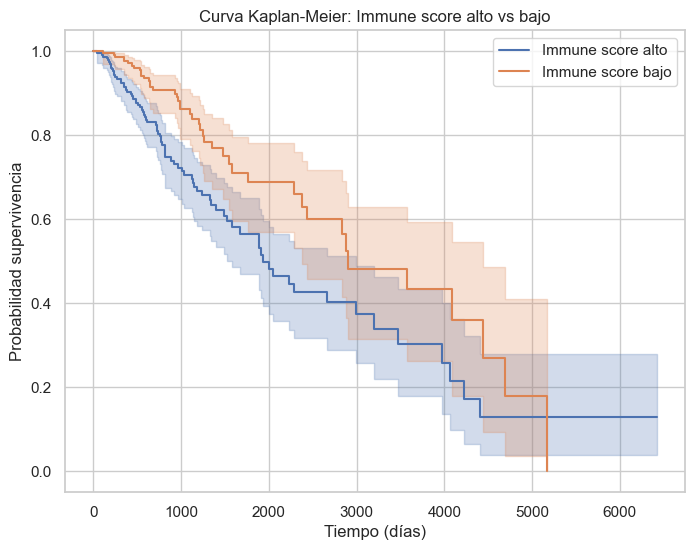

P-valor test log-rank (immune score): 0.0013


In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Definir grupos high y low según mediana es común
median_immune = scores_sub['immune_score'].median()
high_immune = scores_sub['immune_score'] >= median_immune

# Supervivencia Kaplan-Meier para high vs low immune
kmf = KaplanMeierFitter()
T = clin_sub['overall_survival']  # Tiempo supervivencia (ej: días)
E = clin_sub['status']  # Evento (1 muerto, 0 censurado)

plt.figure(figsize=(8,6))
kmf.fit(T[high_immune], event_observed=E[high_immune], label='Immune score alto')
ax = kmf.plot_survival_function()
kmf.fit(T[~high_immune], event_observed=E[~high_immune], label='Immune score bajo')
kmf.plot_survival_function(ax=ax)
plt.title('Curva Kaplan-Meier: Immune score alto vs bajo')
plt.xlabel('Tiempo (días)')
plt.ylabel('Probabilidad supervivencia')
plt.show()

# Test log-rank para comparar grupos
result_logrank = logrank_test(T[high_immune], T[~high_immune], event_observed_A=E[high_immune], event_observed_B=E[~high_immune])
print(f"P-valor test log-rank (immune score): {result_logrank.p_value:.4f}")


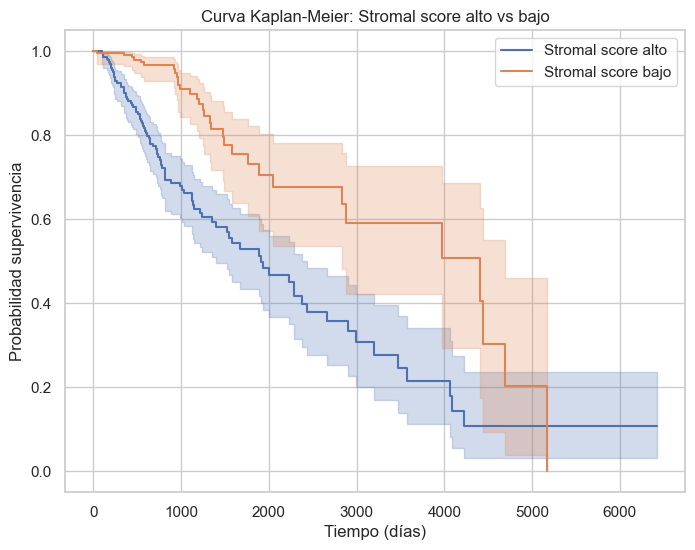

P-valor test log-rank (stromal score): 0.0000


In [92]:
# Definir grupos high y low según mediana es común
median_stromal = scores_sub['stromal_score'].median()
high_stromal = scores_sub['stromal_score'] >= median_stromal

plt.figure(figsize=(8,6))
kmf.fit(T[high_stromal], event_observed=E[high_stromal], label='Stromal score alto')
ax = kmf.plot_survival_function()
kmf.fit(T[~high_stromal], event_observed=E[~high_stromal], label='Stromal score bajo')
kmf.plot_survival_function(ax=ax)
plt.title('Curva Kaplan-Meier: Stromal score alto vs bajo')
plt.xlabel('Tiempo (días)')
plt.ylabel('Probabilidad supervivencia')
plt.show()

# Test log-rank para comparar grupos
result_logrank = logrank_test(T[high_stromal], T[~high_stromal], event_observed_A=E[high_stromal], event_observed_B=E[~high_stromal])
print(f"P-valor test log-rank (stromal score): {result_logrank.p_value:.4f}")

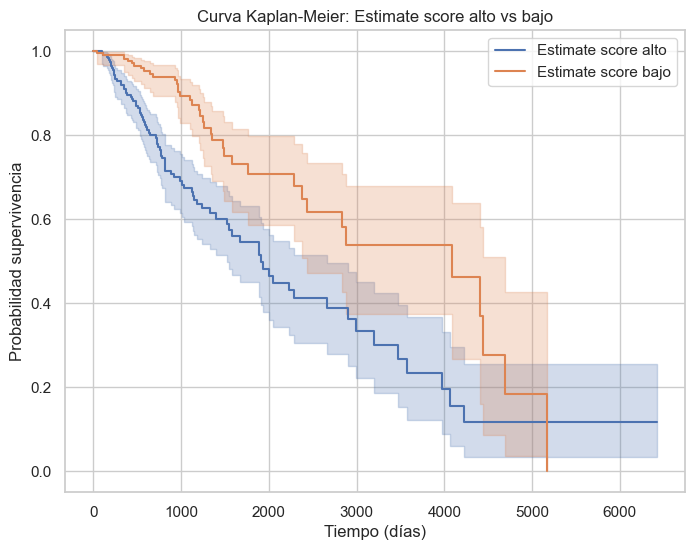

P-valor test log-rank (estimate score): 0.0000


In [93]:
# Definir grupos high y low según mediana es común
median_estimate = scores_sub['estimate_score'].median()
high_estimate = scores_sub['estimate_score'] >= median_estimate

plt.figure(figsize=(8,6))
kmf.fit(T[high_estimate], event_observed=E[high_estimate], label='Estimate score alto')
ax = kmf.plot_survival_function()
kmf.fit(T[~high_estimate], event_observed=E[~high_estimate], label='Estimate score bajo')
kmf.plot_survival_function(ax=ax)
plt.title('Curva Kaplan-Meier: Estimate score alto vs bajo')
plt.xlabel('Tiempo (días)')
plt.ylabel('Probabilidad supervivencia')
plt.show()

# Test log-rank para comparar grupos
result_logrank = logrank_test(T[high_estimate], T[~high_estimate], event_observed_A=E[high_estimate], event_observed_B=E[~high_estimate])
print(f"P-valor test log-rank (estimate score): {result_logrank.p_value:.4f}")

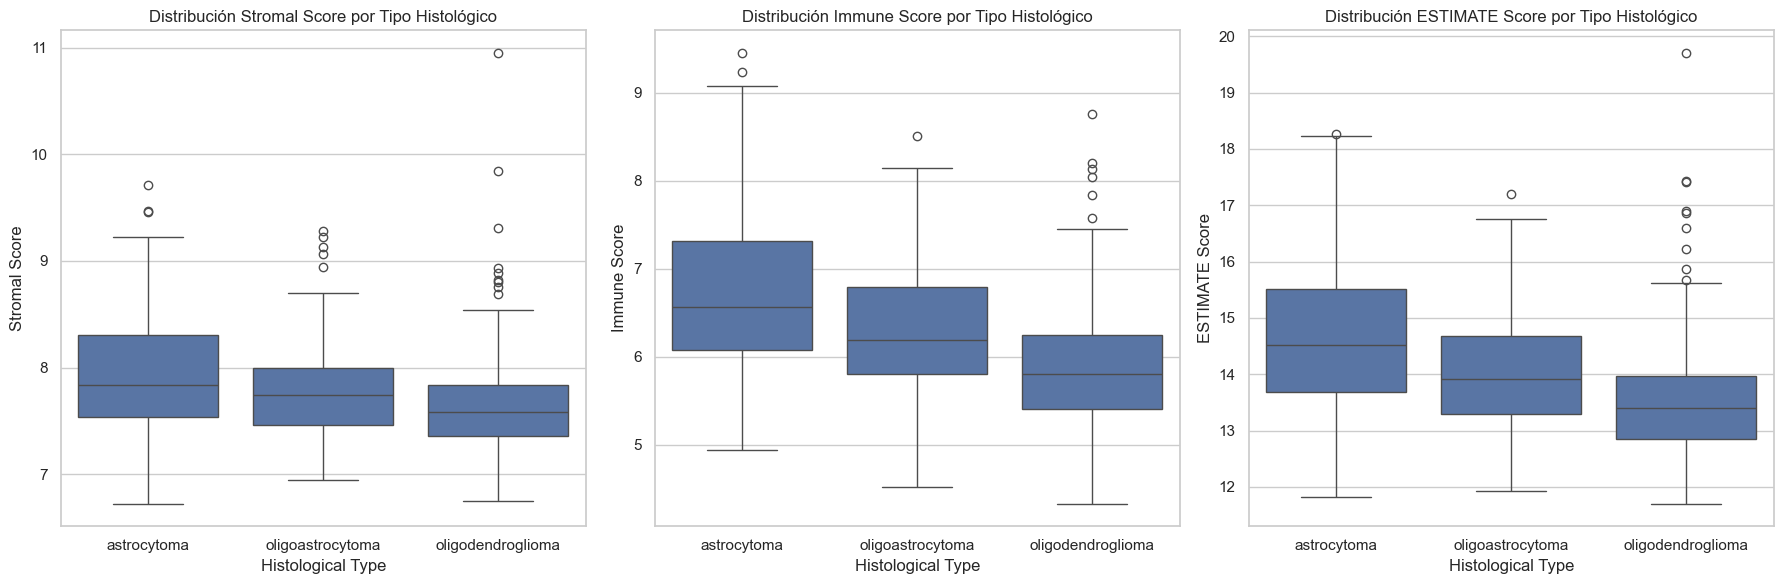

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

data = scores_sub.join(clin['histological_type'])
data = data.dropna(subset=['stromal_score', 'immune_score', 'estimate_score', 'histological_type'])

# Configurar estilo
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot para Stromal Score
sns.boxplot(x='histological_type', y='stromal_score', data=data, ax=axes[0])
axes[0].set_title('Distribución Stromal Score por Tipo Histológico')
axes[0].set_xlabel('Histological Type')
axes[0].set_ylabel('Stromal Score')

# Boxplot para Immune Score
sns.boxplot(x='histological_type', y='immune_score', data=data, ax=axes[1])
axes[1].set_title('Distribución Immune Score por Tipo Histológico')
axes[1].set_xlabel('Histological Type')
axes[1].set_ylabel('Immune Score')

# Boxplot para ESTIMATE Score
sns.boxplot(x='histological_type', y='estimate_score', data=data,
ax=axes[2])
axes[2].set_title('Distribución ESTIMATE Score por Tipo Histológico')
axes[2].set_xlabel('Histological Type')
axes[2].set_ylabel('ESTIMATE Score')

plt.tight_layout()
plt.show()

## Identificación de genes diferencialmente expresados (DEGs)

La identificación de genes diferencialemente expresados entre grupos alto y bajo puntajes immune y stromal mediante los siguientes criterios:
- $|\log_2(\text{FC})| > 1$ (Fold Change)
- FDR (False Discovery Rate) < 0.05

Son intersectadas las listas de DEGs comunes a ambos puntajes.

In [95]:
scores_sub.head()

immune_score  stromal_score  estimate_score
TCGA.CS.6665      7.928820       8.307347       16.236166
TCGA.CS.6670      5.218867       7.616709       12.835575
TCGA.DB.A4XC      6.620606       7.846267       14.466873
TCGA.DH.5141      5.894965       7.715391       13.610356
TCGA.DH.A66B      7.272471       7.539039       14.811510

In [96]:
from scipy.stats import ttest_ind

common_samples = expr.columns.intersection(scores_sub.index)

# Subconjunto las muestras comunes para ambos datasets
expr_common = expr.loc[:, common_samples]
scores_sub_common = scores_sub.loc[common_samples]

scores_names = ['immune_score', 'stromal_score', 'estimate_score']

# Diccionarios para guardar resultados por score
deg_results = {}

for score_name in scores_names:
    print(f"Procesando DEGs para {score_name} ...")
    median_score = scores_sub_common[score_name].median()
    
    # Definir grupos alto y bajo para ese score
    high_group = scores_sub_common[score_name] >= median_score
    low_group = ~high_group
    
    # Seleccionar expresión para grupos alto/bajo (los genes están en filas)
    expr_high = expr_common.loc[:, high_group.index[high_group]].copy()
    expr_low = expr_common.loc[:, low_group.index[low_group]].copy()
    
    # Vectores para p-values y logFC
    pvals = []
    logFC = []
    genes = expr_common.index
    
    # Calcular t-test y fc para cada gen
    for gene in genes:
        group1 = expr_high.loc[gene].values
        group2 = expr_low.loc[gene].values
        
        # t-test con varianza desigual (Welch)
        stat, p = ttest_ind(group1, group2, equal_var=False)
        pvals.append(p)
        
        # Fold change promedio (diferencia de medias)
        fc = group1.mean() - group2.mean()  # log2 fold change si expresión es log2-transformada
        logFC.append(fc)
        
    # Crear DataFrame con resultados
    deg_df = pd.DataFrame({
        'gene': genes,
        'logFC': logFC,
        'p_value': pvals
    })
    
    # Corrección Bonferroni (ajuste simple)
    deg_df['adj_p_value'] = deg_df['p_value'] * len(deg_df)
    deg_df['adj_p_value'] = deg_df['adj_p_value'].clip(upper=1)  # corregir valores >1
    
    # Filtrar DEGs significativos: |logFC| > 1 y adj_p_value < 0.05
    deg_sig = deg_df[(deg_df['adj_p_value'] < 0.05) & (deg_df['logFC'].abs() > 1)].copy()
    deg_sig = deg_sig.sort_values('adj_p_value')
    
    # Guardar resultados
    deg_results[score_name] = {
        'all': deg_df,
        'significant': deg_sig
    }
    
    print(f"Score {score_name}: genes diferencialmente expresados significativos = {len(deg_sig)}")
    print(deg_sig.head(), '\n')

Procesando DEGs para immune_score ...
Score immune_score: genes diferencialmente expresados significativos = 1237
          gene     logFC       p_value   adj_p_value
7828   HLA-DRA  2.540546  3.579583e-91  7.189951e-87
3336      CD74  2.255857  9.008415e-91  1.809430e-86
7819   HLA-DOA  2.550684  6.808441e-87  1.367543e-82
7821  HLA-DPA1  2.396949  1.197575e-84  2.405449e-80
7817   HLA-DMA  1.883692  1.951171e-83  3.919121e-79 

Procesando DEGs para stromal_score ...
Score stromal_score: genes diferencialmente expresados significativos = 855
          gene     logFC       p_value   adj_p_value
8544     ITGA5  1.440245  5.886141e-59  1.182290e-54
5849   FAM129A  1.695183  8.655097e-53  1.738463e-48
4006    COL1A2  1.810255  1.901203e-51  3.818757e-47
3602       CFH  1.461562  5.773508e-50  1.159667e-45
11350     MYOF  1.405933  1.320486e-49  2.652328e-45 

Procesando DEGs para estimate_score ...
Score estimate_score: genes diferencialmente expresados significativos = 1248
          gen

## Análisis funcional y enriquecimiento

Análisis de enriquecimiento funcional con:
- Gene Ontology: procesos biológicos, funciones moleculares y componentes celulares.
- KEGG: rutas metaólicas y de señalización.

In [101]:
import gseapy as gp

# Preparar lista de genes up-regulados y down-regulados
genes_up = deg_sig[deg_sig['logFC'] > 1]['gene'].tolist()
genes_down = deg_sig[deg_sig['logFC'] < -1]['gene'].tolist()

# Enriquecimiento KEGG por ejemplo para genes up
enr_up = gp.enrichr(
    gene_list=genes_up,
    gene_sets=['KEGG_2021_Human'],
    organism='Human',
    outdir=None,  # no genera archivos
    cutoff=0.05
)
print("Enriquecimiento KEGG - genes UP regulados (top 5):")
print(enr_up.results.head())


Enriquecimiento KEGG - genes UP regulados (top 5):
          Gene_set                             Term Overlap       P-value  \
0  KEGG_2021_Human  Staphylococcus aureus infection   42/95  5.505934e-29   
1  KEGG_2021_Human                        Phagosome  49/152  4.342931e-26   
2  KEGG_2021_Human       Osteoclast differentiation  43/127  5.113150e-24   
3  KEGG_2021_Human       Hematopoietic cell lineage   37/99  1.410812e-22   
4  KEGG_2021_Human                    Leishmaniasis   33/77  1.597991e-22   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      1.486602e-26            0                     0   15.076535   
1      5.862957e-24            0                     0    9.090890   
2      4.601835e-22            0                     0    9.732892   
3      8.629153e-21            0                     0   11.291517   
4      8.629153e-21            0                     0   14.147557   

   Combined Score                                              Ge

In [102]:
print(genes_up)

['HLA-DRA', 'CD74', 'HLA-DPA1', 'HLA-DOA', 'HLA-DPB1', 'HLA-DRB1', 'HLA-DMA', 'PLBD1', 'CASP4', 'SP100', 'CIITA', 'ADPRH', 'KYNU', 'SERPINA1', 'SQRDL', 'MSR1', 'HLA-DMB', 'HLA-E', 'CCR5', 'HLA-DQA1', 'S100A4', 'RAC2', 'FAM129A', 'S100A11', 'GPR65', 'CLIC1', 'PTGER4', 'IL2RG', 'GBP5', 'TRIM38', 'FGL2', 'CTSC', 'APOBEC3G', 'FCGR2A', 'CASP8', 'IFI30', 'DENND2D', 'ARHGAP15', 'LTBR', 'TNFAIP8', 'CECR1', 'CTSS', 'PLSCR1', 'MSN', 'FCGR2C', 'ELF4', 'CASP1', 'ITGAL', 'CD7', 'CCL5', 'MYOF', 'ARHGAP25', 'SP140L', 'HLA-DRB5', 'CD3E', 'CD2', 'PDCD1LG2', 'FBP1', 'SLC15A3', 'CHI3L2', 'PTPRC', 'CTSZ', 'LYN', 'MX2', 'LAIR1', 'RAB32', 'CARD16', 'FCGR3A', 'SERPINB1', 'ARHGDIB', 'PTPN7', 'MYL12A', 'TLR8', 'CSF2RB', 'TYMP', 'DAPP1', 'MYO1F', 'CYTIP', 'CD69', 'B2M', 'C16orf54', 'TGFBR2', 'APOBEC3C', 'ANXA2P2', 'HLA-B', 'ITGB2', 'RBM47', 'EPSTI1', 'GAPT', 'TRAF3IP3', 'LRRC25', 'LY96', 'GBP1', 'ARPC1B', 'OLFML3', 'SLAMF6', 'LCP2', 'C1R', 'RHOH', 'ITGA5', 'EMR1', 'TNFRSF1B', 'PLCG2', 'SPINT1', 'SERPING1', 'TYR

In [104]:
# Enriquecimiento GO para genes up regulados (BP, CC, MF)
enr_go_bp_up = gp.enrichr(
    gene_list=genes_up,
    gene_sets=['GO_Biological_Process_2025'],
    organism='Human',
    outdir=None,
    cutoff=0.05
)
print("Enriquecimiento GO BP - genes UP regulados (top 5):")
print(enr_go_bp_up.results.head())

enr_go_cc_up = gp.enrichr(
    gene_list=genes_up,
    gene_sets=['GO_Cellular_Component_2025'],
    organism='Human',
    outdir=None,
    cutoff=0.05
)
print("Enriquecimiento GO CC - genes UP regulados (top 5):")
print(enr_go_cc_up.results.head())

enr_go_mf_up = gp.enrichr(
    gene_list=genes_up,
    gene_sets=['GO_Molecular_Function_2025'],
    organism='Human',
    outdir=None,
    cutoff=0.05
)
print("Enriquecimiento GO MF - genes UP regulados (top 5):")
print(enr_go_mf_up.results.head())

Enriquecimiento GO BP - genes UP regulados (top 5):
                     Gene_set  \
0  GO_Biological_Process_2025   
1  GO_Biological_Process_2025   
2  GO_Biological_Process_2025   
3  GO_Biological_Process_2025   
4  GO_Biological_Process_2025   

                                                Term Overlap       P-value  \
0                 Inflammatory Response (GO:0006954)  76/261  2.014922e-36   
1  Positive Regulation of Cytokine Production (GO...  82/325  3.215103e-34   
2   Cytokine-Mediated Signaling Pathway (GO:0019221)  64/255  9.053124e-27   
3    Regulation of T Cell Proliferation (GO:0042129)   36/83  1.133883e-24   
4  Regulation of Tumor Necrosis Factor Production...  44/131  2.204612e-24   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      6.344990e-33            0                     0    8.036059   
1      5.062180e-31            0                     0    6.621986   
2      9.502763e-24            0                     0    6.471635   


## Red de interacciones de proteínas

In [105]:
import requests

def get_string_edges(genes, species=9606, min_score=900):
    """
    Consulta a la API STRING para obtener interacciones
    genes: lista de genes (símbolos)
    species: 9606 para humano
    min_score: umbral mínimo de confiabilidad (900 = 0.9)
    Retorna lista de tuplas (protein1, protein2)
    """
    
    # genes en un string separados por "%0d" para la API
    genes_str = "%0d".join(genes)
    
    url = f"https://string-db.org/api/tsv/network?identifiers={genes_str}&species={species}&required_score={min_score}"
    
    response = requests.get(url)
    edges = []
    if response.ok:
        lines = response.text.strip().split('\n')
        # Salta la primera línea (header)
        for line in lines[1:]:
            fields = line.split('\t')
            protein1 = fields[2].upper()
            protein2 = fields[3].upper()
            # Validar que ambos estén en los genes (mayúsculas vs minúsculas)
            if protein1 in (g.upper() for g in genes) and protein2 in (g.upper() for g in genes):
                edges.append((protein1, protein2))
    else:
        print("Error al consultar STRING API:", response.status_code)
    return edges

# Ejemplo: usar genes up regulados para obtener aristas
edges_up = get_string_edges(genes_up)

print(f"Aristas (interacciones) obtenidas para genes up: {len(edges_up)}")
print("Primeras 10 aristas:")
print(edges_up[:10])


Error al consultar STRING API: 414
Aristas (interacciones) obtenidas para genes up: 0
Primeras 10 aristas:
[]


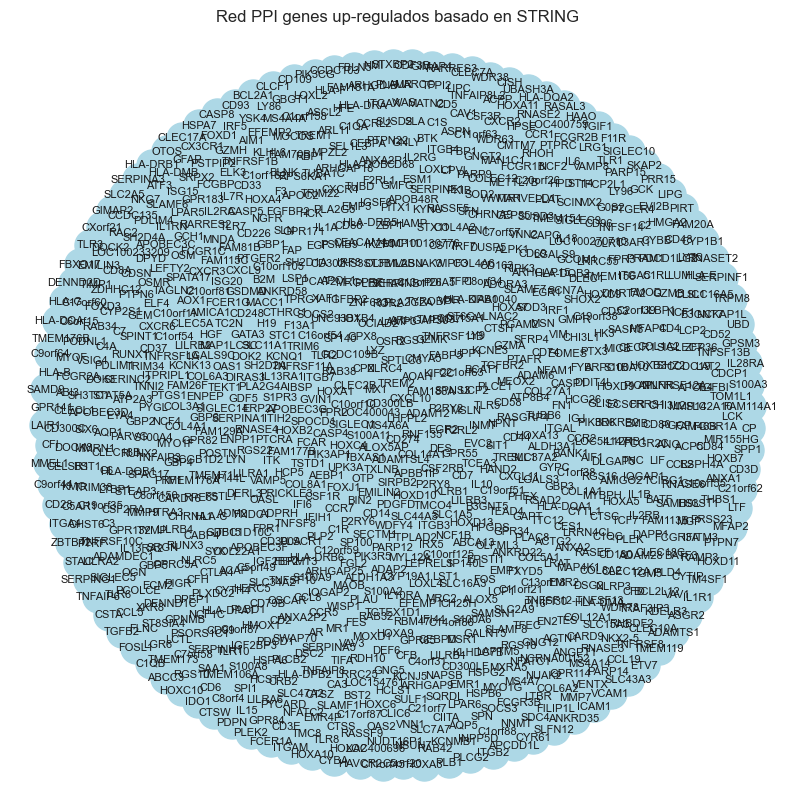

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(genes_up)
G.add_edges_from(edges_up)

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Red PPI genes up-regulados basado en STRING")
plt.axis('off')
plt.show()


In [ ]:
degree_dict = dict(G.degree)
# Ordenar genes por grado descendente
hub_genes_sorted = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
top_hubs = [gene for gene, deg in hub_genes_sorted[:25]]  # por ejemplo, top 25

print("Top 25 genes hub seleccionados:", top_hubs)


Top 25 genes hub seleccionados: ['HLA-DRA', 'CD74', 'HLA-DPA1', 'HLA-DOA', 'HLA-DPB1', 'HLA-DRB1', 'HLA-DMA', 'PLBD1', 'CASP4', 'SP100', 'CIITA', 'ADPRH', 'KYNU', 'SERPINA1', 'SQRDL', 'MSR1', 'HLA-DMB', 'HLA-E', 'CCR5', 'HLA-DQA1', 'S100A4', 'RAC2', 'FAM129A', 'S100A11', 'GPR65']


In [ ]:
clin.head()

attrib_name   years_to_birth  Tumor_purity  histological_type  gender  \
TCGA.CS.6665            51.0        0.6573        astrocytoma  female   
TCGA.CS.6670            43.0        0.9816  oligodendroglioma    male   
TCGA.DB.A4XC            26.0        0.8892   oligoastrocytoma    male   
TCGA.DH.5141            32.0        0.9387  oligodendroglioma    male   
TCGA.DH.A66B            52.0        0.8806        astrocytoma    male   

attrib_name  radiation_therapy   race            ethnicity  overall_survival  \
TCGA.CS.6665               yes  white  nothispanicorlatino            1568.0   
TCGA.CS.6670               NaN  white  nothispanicorlatino            1426.0   
TCGA.DB.A4XC               yes  white  nothispanicorlatino            1421.0   
TCGA.DH.5141               yes  white     hispanicorlatino             968.0   
TCGA.DH.A66B               yes  white  nothispanicorlatino            1279.0   

attrib_name   status  
TCGA.CS.6665     0.0  
TCGA.CS.6670     0.0  
TCGA.DB.A4XC     0.0  
TCGA.DH.5141     0.0  
TCGA.DH.A66B     0.0

In [ ]:
expr.T.head()

attrib_name     A1BG  A1CF   A2BP1   A2LD1   A2ML1      A2M  A4GALT   A4GNT  \
TCGA.CS.4938  6.5715   0.0  4.5641  3.8564  7.1997  13.8518  6.2176  0.0000   
TCGA.CS.4941  6.1944   0.0  9.0375  7.1808  9.0290  14.1314  7.3288  1.0252   
TCGA.CS.4942  6.2375   0.0  8.5295  5.7117  7.4545  14.2341  5.5011  0.4287   
TCGA.CS.4943  4.9535   0.0  5.5235  3.9052  7.4920  13.5168  5.1915  1.2043   
TCGA.CS.4944  4.6844   0.0  6.7335  4.2491  7.3253  13.4115  6.8579  0.5892   

attrib_name   AAA1     AAAS  ...    ZXDA    ZXDB     ZXDC  ZYG11A   ZYG11B  \
TCGA.CS.4938   0.0   9.1944  ...  6.0266  9.0339  10.3581  0.0000  10.5476   
TCGA.CS.4941   0.0   8.4955  ...  6.7406  8.8721  10.2618  0.4277  10.7750   
TCGA.CS.4942   0.0   9.1342  ...  6.8608  8.8308  10.1078  0.4287  10.6322   
TCGA.CS.4943   0.0  10.2793  ...  6.4921  8.9427  10.3324  2.0911  10.7823   
TCGA.CS.4944   0.0   9.0637  ...  5.4385  8.3434   9.9855  0.5892  10.2598   

attrib_name       ZYX    ZZEF1    ZZZ3  psiTPTE22  tAKR  
TCGA.CS.4938  10.6438  10.1957  9.7094     9.6052   0.0  
TCGA.CS.4941  11.9259  10.7387  9.9894     4.3204   0.0  
TCGA.CS.4942  11.1134  10.4766  9.4674    10.7374   0.0  
TCGA.CS.4943  11.0584  10.9054  9.4311     8.0716   0.0  
TCGA.CS.4944  10.7259   9.5133  8.8390     4.3694   0.0  

[5 rows x 20086 columns]

Cox

Cantidad de muestras comunes: 481


<lifelines.CoxPHFitter: fitted with 481 total observations, 358 right-censored observations>
             duration col = 'overall_survival'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 481
number of events observed = 123
   partial log-likelihood = -549.14
         time fit was run = 2025-08-08 22:31:02 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
HLA-DRA    0.04      1.04      0.44           -0.83            0.91                0.44                2.48
CD74      -0.28      0.76      0.43           -1.12            0.57                0.33                1.76
HLA-DPA1   0.25      1.29      0.32           -0.38            0.88                0.68                2.42
HLA-DOA   -0.32      0.73      0.31           -0.92            0.29                0.40                1.33
HLA-DPB1   0.52      1.69      0.31           -0.08            1.13                0.92                3.09
HLA-DRB1  -0.17      0.85      0.22           -0.60            0.26                0.55                1.30
HLA-DMA   -1.33      0.26      0.47           -2.25           -0.41                0.11                0.66
PLBD1      0.01      1.01      0.17           -0.32            0.35                0.72                1.42
CASP4      0.42      1.52      0.25           -0.06            0.90                0.94                2.46
SP100      0.53      1.69      0.29           -0.05            1.10                0.95                3.01
CIITA      0.59      1.81      0.17            0.27            0.92                1.31                2.51
ADPRH      0.44      1.55      0.29           -0.13            1.01                0.88                2.75
KYNU      -0.12      0.89      0.17           -0.45            0.21                0.64                1.23
SERPINA1  -0.30      0.74      0.22           -0.73            0.12                0.48                1.12
SQRDL      0.28      1.33      0.27           -0.24            0.81                0.79                2.25
MSR1       0.41      1.51      0.16            0.09            0.73                1.10                2.08
HLA-DMB    0.15      1.16      0.33           -0.50            0.80                0.60                2.23
HLA-E     -0.70      0.50      0.24           -1.17           -0.23                0.31                0.79
CCR5      -0.01      0.99      0.18           -0.37            0.35                0.69                1.41
HLA-DQA1   0.07      1.07      0.14           -0.21            0.35                0.81                1.42
S100A4    -0.08      0.92      0.13           -0.33            0.17                0.72                1.18
RAC2      -0.19      0.82      0.26           -0.71            0.32                0.49                1.38
FAM129A   -0.15      0.86      0.14           -0.43            0.13                0.65                1.14
S100A11    0.54      1.72      0.24            0.08            1.01                1.08                2.74
GPR65     -0.15      0.86      0.22           -0.58            0.29                0.56                1.33

           cmp to     z      p  -log2(p)
covariate                               
HLA-DRA      0.00  0.09   0.93      0.11
CD74         0.00 -0.64   0.52      0.94
HLA-DPA1     0.00  0.78   0.44      1.19
HLA-DOA      0.00 -1.03   0.30      1.72
HLA-DPB1     0.00  1.70   0.09      3.49
HLA-DRB1     0.00 -0.76   0.45      1.16
HLA-DMA      0.00 -2.84 <0.005      7.80
PLBD1        0.00  0.08   0.94      0.09
CASP4        0.00  1.70   0.09      3.49
SP100        0.00  1.80   0.07      3.79
CIITA        0.00  3.59 <0.005     11.57
ADPRH        0.00  1.52   0.13      2.95
KYNU         0.00 -0.72   0.47      1.09
SERPINA1     0.00 -1.42   0.16      2.68
SQRDL        0.00  1.06   0.29      1.80
MSR1         0.0

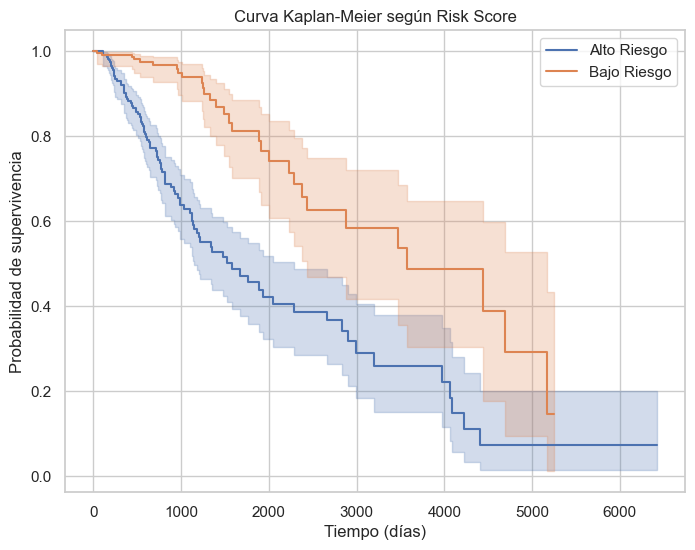

In [ ]:
from lifelines import CoxPHFitter

# Preparamos DataFrame de expresión transpuesta: muestras filas, genes columnas
expr_T = expr.loc[top_hubs].T

common_samples = expr_T.index.intersection(clin.index)
print(f"Cantidad de muestras comunes: {len(common_samples)}")

expr_T_sub = expr_T.loc[common_samples]
clin_sub = clin.loc[common_samples]

data_cox = expr_T.join(clin_sub[['overall_survival', 'status']])

# Eliminar muestras con datos faltantes
data_cox = data_cox.dropna()

cph = CoxPHFitter()
cph.fit(data_cox, duration_col='overall_survival', event_col='status')
cph.print_summary()

# Calcular risk score: suma ponderada coef * expresión
beta = cph.params_
risk_score = data_cox[top_hubs].dot(beta)

data_cox['risk_score'] = risk_score

# Dividir en grupos risk alto y bajo según mediana
median_rs = risk_score.median()
high_risk = risk_score >= median_rs

# Visualizar curvas Kaplan-Meier para riesgo alto y bajo
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))
kmf.fit(data_cox.loc[high_risk, 'overall_survival'], event_observed=data_cox.loc[high_risk, 'status'], label='Alto Riesgo')
ax = kmf.plot_survival_function()
kmf.fit(data_cox.loc[~high_risk, 'overall_survival'], event_observed=data_cox.loc[~high_risk, 'status'], label='Bajo Riesgo')
kmf.plot_survival_function(ax=ax)
plt.title('Curva Kaplan-Meier según Risk Score')
plt.xlabel('Tiempo (días)')
plt.ylabel('Probabilidad de supervivencia')
plt.show()
